In [79]:
import os 
os.getcwd()
import numpy as np
import sklearn.preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Clean data
import re


In [80]:
def look_n_load(path):
    df = pd.read_csv(path)
    print('\nShape:', df.shape)
    print('\nColumns:', list(df.columns))
#     print('\n',df.describe())
    print('\nMissing proportions:\n', df.isna().sum()/len(df))
    return df

In [81]:
triage = look_n_load('triage.csv')



Shape: (447712, 11)

Columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

Missing proportions:
 subject_id        0.000000
stay_id           0.000000
temperature       0.054935
heartrate         0.040111
resprate          0.047743
o2sat             0.048355
sbp               0.042941
dbp               0.044823
pain              0.030415
acuity            0.016368
chiefcomplaint    0.000051
dtype: float64


In [83]:
vitalsign = look_n_load('vitalsign.csv')



Shape: (1646976, 11)

Columns: ['subject_id', 'stay_id', 'charttime', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain']

Missing proportions:
 subject_id     0.000000
stay_id        0.000000
charttime      0.000000
temperature    0.360779
heartrate      0.044546
resprate       0.057115
o2sat          0.086914
sbp            0.051936
dbp            0.051936
rhythm         0.961874
pain           0.283495
dtype: float64


In [84]:
edstays = look_n_load('edstays.csv')



Shape: (447712, 9)

Columns: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']

Missing proportions:
 subject_id           0.000000
hadm_id              0.522213
stay_id              0.000000
intime               0.000000
outtime              0.000000
gender               0.000000
race                 0.000000
arrival_transport    0.000000
disposition          0.000000
dtype: float64


In [85]:
diagnosis = look_n_load('diagnosis.csv')



Shape: (946692, 6)

Columns: ['subject_id', 'stay_id', 'seq_num', 'icd_code', 'icd_version', 'icd_title']

Missing proportions:
 subject_id     0.0
stay_id        0.0
seq_num        0.0
icd_code       0.0
icd_version    0.0
icd_title      0.0
dtype: float64


In [86]:
# creating hours column of for lenght of stay
if type(edstays['intime'][0]) == type('str'): 
    edstays['intime'] = pd.to_datetime(edstays['intime'])
    edstays['outtime'] = pd.to_datetime(edstays['outtime'])

    edstays['difftime'] = edstays['outtime'] - edstays['intime']
    edstays['nights'] = [x.days for x in edstays.difftime]
    edstays['hours'] = [round(x.total_seconds() / 60 / 60, 1) for x in edstays.difftime]

    # need to ensure exact time of dishcarge has been maintained and only the date ambiguated 
    edstays['discharge_hour'] = [x.hour for x in edstays.outtime]
    edstays['admission_hour'] = [x.hour for x in edstays.intime]

    edstays['admission_date'] = [x.date() for x in edstays.intime]
    edstays['admission_day'] = [x.day for x in edstays.intime]

patients_seen = pd.DataFrame(edstays['admission_date'].value_counts()).reset_index()
patients_seen = patients_seen.rename(columns={'index':'admission_date', 'admission_date':'patients_seen'})

edstays
# # overnight stays, not just hours

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,difftime,nights,hours,discharge_hour,admission_hour,admission_date,admission_day
0,10000032,22595853.0,33258284,2180-06-05 19:17:00,2180-06-05 23:30:00,F,WHITE,AMBULANCE,ADMITTED,0 days 04:13:00,0,4.2,23,19,2180-06-05,5
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,0 days 05:37:00,0,5.6,21,15,2180-06-26,26
2,10000032,25742920.0,35968195,2180-05-08 20:58:00,2180-06-08 01:44:00,F,WHITE,AMBULANCE,ADMITTED,30 days 04:46:00,30,724.8,1,20,2180-05-08,8
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,0 days 13:30:00,0,13.5,5,16,2180-07-22,22
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,0 days 08:06:00,0,8.1,14,5,2180-07-23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447707,19999784,26194817.0,35692999,2119-06-18 14:21:00,2119-06-18 21:09:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,0 days 06:48:00,0,6.8,21,14,2119-06-18,18
447708,19999828,25744818.0,32917002,2149-08-01 09:11:00,2149-08-01 18:12:00,F,WHITE,AMBULANCE,ADMITTED,0 days 09:01:00,0,9.0,18,9,2149-08-01,1
447709,19999828,29734428.0,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,1 days 00:16:00,1,24.3,17,17,2147-07-17,17
447710,19999914,NaN,32002659,2158-12-24 11:41:00,2158-12-24 11:56:00,F,UNKNOWN,UNKNOWN,ELOPED,0 days 00:15:00,0,0.2,11,11,2158-12-24,24


In [87]:
# Looking for values where person is either admitted or transferred for lenght of stay
res=edstays[(edstays.disposition == "ADMITTED") | (edstays.disposition == 'TRANSFER')]
res

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,difftime,nights,hours,discharge_hour,admission_hour,admission_date,admission_day
0,10000032,22595853.0,33258284,2180-06-05 19:17:00,2180-06-05 23:30:00,F,WHITE,AMBULANCE,ADMITTED,0 days 04:13:00,0,4.2,23,19,2180-06-05,5
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,0 days 05:37:00,0,5.6,21,15,2180-06-26,26
2,10000032,25742920.0,35968195,2180-05-08 20:58:00,2180-06-08 01:44:00,F,WHITE,AMBULANCE,ADMITTED,30 days 04:46:00,30,724.8,1,20,2180-05-08,8
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,0 days 08:06:00,0,8.1,14,5,2180-07-23,23
5,10000084,23052089.0,35203156,2160-11-20 20:36:00,2160-11-21 03:20:00,M,WHITE,WALK IN,ADMITTED,0 days 06:44:00,0,6.7,3,20,2160-11-20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447706,19999784,25715748.0,34149746,2119-11-08 09:15:00,2119-11-08 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,0 days 04:25:00,0,4.4,13,9,2119-11-08,8
447707,19999784,26194817.0,35692999,2119-06-18 14:21:00,2119-06-18 21:09:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,0 days 06:48:00,0,6.8,21,14,2119-06-18,18
447708,19999828,25744818.0,32917002,2149-08-01 09:11:00,2149-08-01 18:12:00,F,WHITE,AMBULANCE,ADMITTED,0 days 09:01:00,0,9.0,18,9,2149-08-01,1
447709,19999828,29734428.0,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,1 days 00:16:00,1,24.3,17,17,2147-07-17,17


In [88]:
max = res['hours'].max()

In [89]:

# removed negative hours. grouped length of stay column as stay(hours)
# for predicting
res.loc[res['hours'].between(0,6), 'stay'] = '0-6 '
res.loc[res['hours'].between(6.1,12), 'stay'] = '6-12'
res.loc[res['hours'].between(12.1,24), 'stay'] = '12-24 '
res.loc[res['hours']>24, 'stay'] = '24+'

In [90]:
res

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,difftime,nights,hours,discharge_hour,admission_hour,admission_date,admission_day,stay
0,10000032,22595853.0,33258284,2180-06-05 19:17:00,2180-06-05 23:30:00,F,WHITE,AMBULANCE,ADMITTED,0 days 04:13:00,0,4.2,23,19,2180-06-05,5,0-6
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,0 days 05:37:00,0,5.6,21,15,2180-06-26,26,0-6
2,10000032,25742920.0,35968195,2180-05-08 20:58:00,2180-06-08 01:44:00,F,WHITE,AMBULANCE,ADMITTED,30 days 04:46:00,30,724.8,1,20,2180-05-08,8,24+
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,0 days 08:06:00,0,8.1,14,5,2180-07-23,23,6-12
5,10000084,23052089.0,35203156,2160-11-20 20:36:00,2160-11-21 03:20:00,M,WHITE,WALK IN,ADMITTED,0 days 06:44:00,0,6.7,3,20,2160-11-20,20,6-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447706,19999784,25715748.0,34149746,2119-11-08 09:15:00,2119-11-08 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,0 days 04:25:00,0,4.4,13,9,2119-11-08,8,0-6
447707,19999784,26194817.0,35692999,2119-06-18 14:21:00,2119-06-18 21:09:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,0 days 06:48:00,0,6.8,21,14,2119-06-18,18,6-12
447708,19999828,25744818.0,32917002,2149-08-01 09:11:00,2149-08-01 18:12:00,F,WHITE,AMBULANCE,ADMITTED,0 days 09:01:00,0,9.0,18,9,2149-08-01,1,6-12
447709,19999828,29734428.0,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,1 days 00:16:00,1,24.3,17,17,2147-07-17,17,24+


In [91]:
res.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'difftime', 'nights',
       'hours', 'discharge_hour', 'admission_hour', 'admission_date',
       'admission_day', 'stay'],
      dtype='object')

In [92]:
res['disposition'].value_counts()

ADMITTED    166303
TRANSFER      7436
Name: disposition, dtype: int64

In [93]:
res = res[['subject_id', 'stay_id', 'gender', 'race', 'arrival_transport', 'disposition', 'stay']]
res.head()

,subject_id,stay_id,gender,race,arrival_transport,disposition,stay
0,10000032,33258284,F,WHITE,AMBULANCE,ADMITTED,0-6
1,10000032,38112554,F,WHITE,AMBULANCE,ADMITTED,0-6
2,10000032,35968195,F,WHITE,AMBULANCE,ADMITTED,24+
4,10000032,39399961,F,WHITE,AMBULANCE,ADMITTED,6-12
5,10000084,35203156,M,WHITE,WALK IN,ADMITTED,6-12


In [94]:
triage.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [95]:
triage = triage[['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
                'chiefcomplaint']]
triage.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [96]:
df = res.merge(triage, how='inner', on=['subject_id', 'stay_id'])
df.head()

,subject_id,stay_id,gender,race,arrival_transport,disposition,stay,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,33258284,F,WHITE,AMBULANCE,ADMITTED,0-6,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
1,10000032,38112554,F,WHITE,AMBULANCE,ADMITTED,0-6,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
2,10000032,35968195,F,WHITE,AMBULANCE,ADMITTED,24+,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,39399961,F,WHITE,AMBULANCE,ADMITTED,6-12,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"
4,10000084,35203156,M,WHITE,WALK IN,ADMITTED,6-12,97.5,78.0,16.0,100.0,114.0,71.0,0,2.0,"Confusion, Hallucinations"


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173739 entries, 0 to 173738
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         173739 non-null  int64  
 1   stay_id            173739 non-null  int64  
 2   gender             173739 non-null  object 
 3   race               173739 non-null  object 
 4   arrival_transport  173739 non-null  object 
 5   disposition        173739 non-null  object 
 6   stay               170162 non-null  object 
 7   temperature        157889 non-null  float64
 8   heartrate          161315 non-null  float64
 9   resprate           159569 non-null  float64
 10  o2sat              159549 non-null  float64
 11  sbp                160954 non-null  float64
 12  dbp                160569 non-null  float64
 13  pain               165279 non-null  object 
 14  acuity             169039 non-null  float64
 15  chiefcomplaint     173733 non-null  object 
dtypes:

In [98]:
df.isna().sum()

subject_id               0
stay_id                  0
gender                   0
race                     0
arrival_transport        0
disposition              0
stay                  3577
temperature          15850
heartrate            12424
resprate             14170
o2sat                14190
sbp                  12785
dbp                  13170
pain                  8460
acuity                4700
chiefcomplaint           6
dtype: int64

In [99]:
len(df)

173739

In [100]:
df = df.dropna()
len(df)

148835

In [101]:
df.drop(columns=['pain'], inplace=True)

In [102]:
df.columns

Index(['subject_id', 'stay_id', 'gender', 'race', 'arrival_transport',
       'disposition', 'stay', 'temperature', 'heartrate', 'resprate', 'o2sat',
       'sbp', 'dbp', 'acuity', 'chiefcomplaint'],
      dtype='object')

In [103]:
df['Stay'] = df['stay']

In [104]:
df.drop(columns=['stay', 'chiefcomplaint', 'subject_id', 'stay_id'], inplace=True)

In [105]:
df.head()

,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,Stay
0,F,WHITE,AMBULANCE,ADMITTED,98.4,70.0,16.0,97.0,106.0,63.0,3.0,0-6
1,F,WHITE,AMBULANCE,ADMITTED,98.9,88.0,18.0,97.0,116.0,88.0,3.0,0-6
2,F,WHITE,AMBULANCE,ADMITTED,99.4,105.0,18.0,96.0,106.0,57.0,3.0,24+
3,F,WHITE,AMBULANCE,ADMITTED,98.7,77.0,16.0,98.0,96.0,50.0,2.0,6-12
4,M,WHITE,WALK IN,ADMITTED,97.5,78.0,16.0,100.0,114.0,71.0,2.0,6-12


In [106]:
from sklearn.preprocessing import LabelEncoder

In [107]:
le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])
df['race'] = le.fit_transform(df['race'])
df['arrival_transport'] = le.fit_transform(df['arrival_transport'])
df['disposition'] = le.fit_transform(df['disposition'])


In [108]:
df.head()

,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,Stay
0,0,28,0,0,98.4,70.0,16.0,97.0,106.0,63.0,3.0,0-6
1,0,28,0,0,98.9,88.0,18.0,97.0,116.0,88.0,3.0,0-6
2,0,28,0,0,99.4,105.0,18.0,96.0,106.0,57.0,3.0,24+
3,0,28,0,0,98.7,77.0,16.0,98.0,96.0,50.0,2.0,6-12
4,1,28,4,0,97.5,78.0,16.0,100.0,114.0,71.0,2.0,6-12


In [109]:
X = df.iloc[:, :-1].values

In [110]:
y = df.iloc[:, -1].values

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Baseline Model - Dummy Classifier

In [113]:
# Build a null model to compare with the model performance
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

# create a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
# fit the dummy classifier
dummy_clf.fit(X_train, y_train)

# predict the test set
y_pred = dummy_clf.predict(X_test)
# print the classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

        0-6      0.4086    1.0000    0.5802     20069
      12-24      0.0000    0.0000    0.0000      3798
         24+     0.0000    0.0000    0.0000      7049
        6-12     0.0000    0.0000    0.0000     18200

    accuracy                         0.4086     49116
   macro avg     0.1022    0.2500    0.1450     49116
weighted avg     0.1670    0.4086    0.2371     49116



In [114]:
print(accuracy_score(y_test, y_pred))

0.4086041208567473


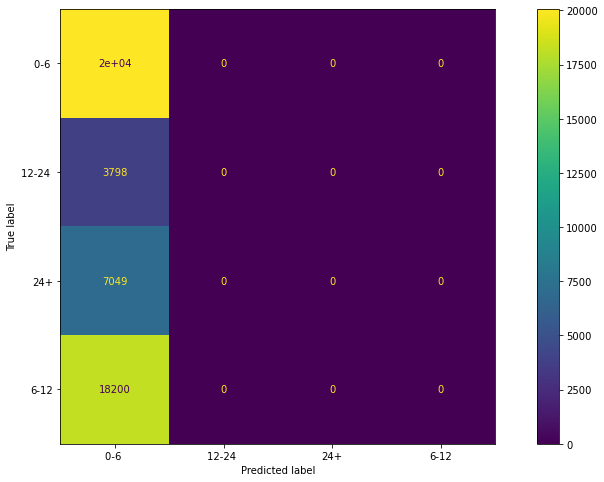

In [115]:
plot_confusion_matrix(dummy_clf, X_test, y_test)

## Random Forest Model¶

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
rfc = RandomForestClassifier(n_estimators=150, max_features='auto', random_state=101)

In [118]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=101)

In [119]:
preds=rfc.predict(X_test)

In [120]:
preds

array(['6-12', '0-6 ', '0-6 ', ..., '6-12', '24+', '0-6 '], dtype=object)

In [121]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

In [122]:
plt.rcParams["figure.figsize"] = (15,8)

In [123]:
print(accuracy_score(y_test, preds))

0.4278239270298884


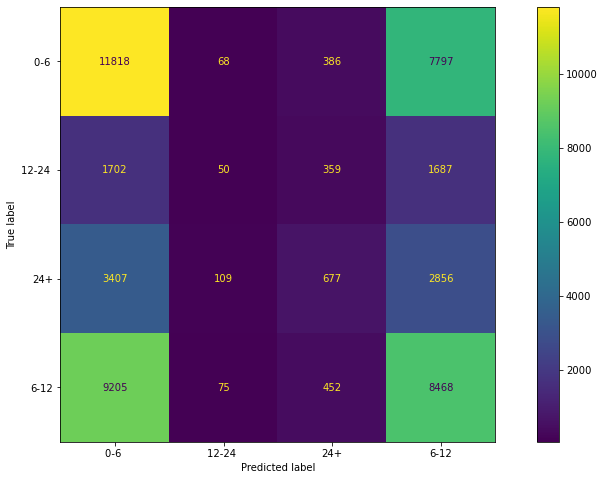

In [124]:
plot_confusion_matrix(rfc, X_test, y_test)

In [125]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        0-6        0.45      0.59      0.51     20069
      12-24        0.17      0.01      0.02      3798
         24+       0.36      0.10      0.15      7049
        6-12       0.41      0.47      0.43     18200

    accuracy                           0.43     49116
   macro avg       0.35      0.29      0.28     49116
weighted avg       0.40      0.43      0.39     49116



Text(0.5, 0, 'Feature Importance')

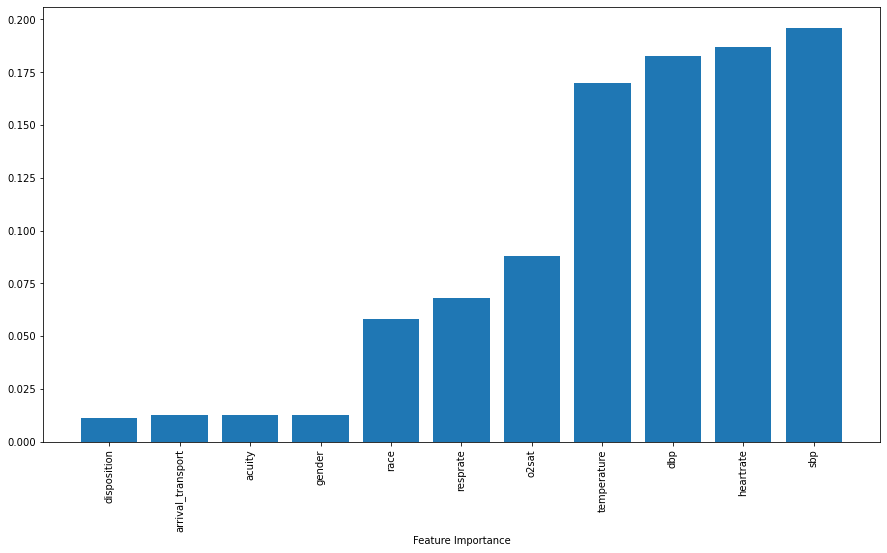

In [126]:
sort = rfc.feature_importances_.argsort()
plt.bar(df.columns[sort], rfc.feature_importances_[sort])
plt.xticks(rotation=90)
plt.xlabel("Feature Importance")

## Decision Tree

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [128]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
# predict the test set
y_pred = dtc.predict(X_test)
# print the classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

        0-6      0.4327    0.4217    0.4271     20069
      12-24      0.0883    0.0987    0.0932      3798
         24+     0.1649    0.1768    0.1706      7049
        6-12     0.3834    0.3740    0.3786     18200

    accuracy                         0.3439     49116
   macro avg     0.2673    0.2678    0.2674     49116
weighted avg     0.3494    0.3439    0.3465     49116



In [129]:
print(accuracy_score(y_test, y_pred))

0.3438797947715612


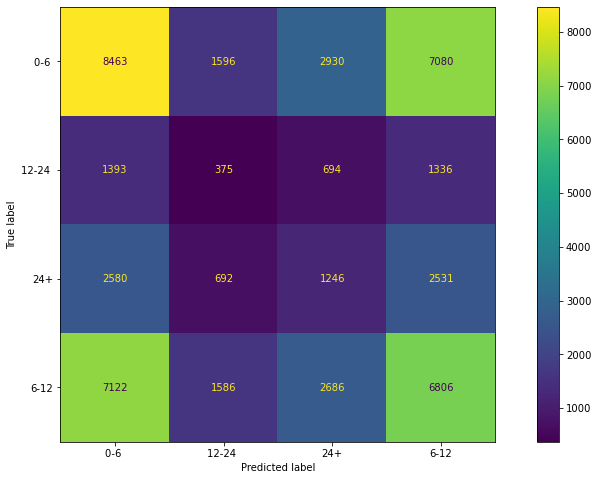

In [130]:
plot_confusion_matrix(dtc, X_test, y_test)

Text(0.5, 0, 'Feature Importance')

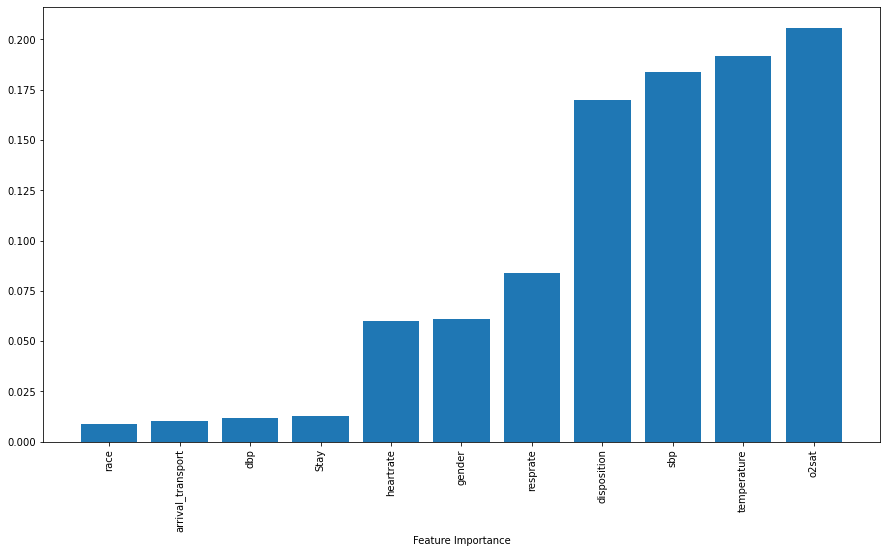

In [147]:
sort = dtc.feature_importances_.argsort()
plt.bar(df.columns[sort], dtc.feature_importances_[sort])
plt.xticks(rotation=90)
plt.xlabel("Feature Importance")

## Support Vector Classifier

In [131]:
# # SVC
#from sklearn.svm import SVC
 
#SVC = SVC(random_state=42)
#SVC.fit(X_train, y_train)

# # predict the test set
#y_pred = SVC.predict(X_test)
# # print the classification_report
#print(classification_report(y_test, y_pred, digits=4))
#print(accuracy_score(y_test, y_pred))

## LDA

In [132]:
# LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldac = LinearDiscriminantAnalysis()
ldac.fit(X_train, y_train)

y_pred = ldac.predict(X_test)
# print the classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

        0-6      0.4697    0.6306    0.5384     20069
      12-24      0.0000    0.0000    0.0000      3798
         24+     0.4085    0.1261    0.1927      7049
        6-12     0.4247    0.4665    0.4446     18200

    accuracy                         0.4487     49116
   macro avg     0.3257    0.3058    0.2939     49116
weighted avg     0.4079    0.4487    0.4124     49116



In [133]:
print(accuracy_score(y_test, y_pred))

0.44865217037218014


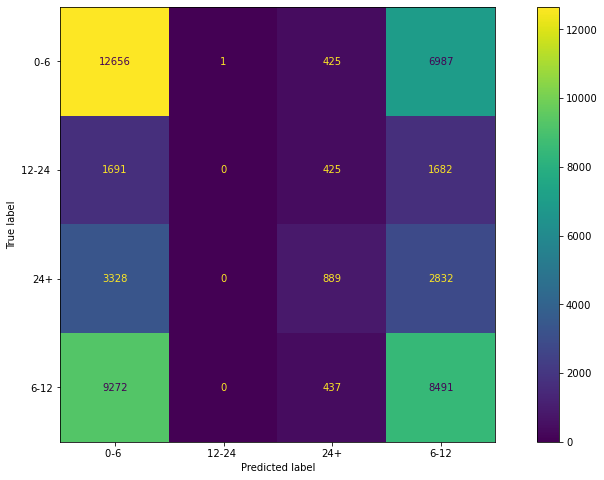

In [134]:
plot_confusion_matrix(ldac, X_test, y_test)

## XGBoost

In [135]:
df['Stay'] = le.fit_transform(df['Stay'])
df.head()

,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,Stay
0,0,28,0,0,98.4,70.0,16.0,97.0,106.0,63.0,3.0,0
1,0,28,0,0,98.9,88.0,18.0,97.0,116.0,88.0,3.0,0
2,0,28,0,0,99.4,105.0,18.0,96.0,106.0,57.0,3.0,2
3,0,28,0,0,98.7,77.0,16.0,98.0,96.0,50.0,2.0,3
4,1,28,4,0,97.5,78.0,16.0,100.0,114.0,71.0,2.0,3


In [136]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [138]:
## Import XGBoost 
from xgboost import XGBClassifier

xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train) 
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4745    0.6222    0.5384     20069
           1     0.1684    0.0042    0.0082      3798
           2     0.4293    0.0994    0.1615      7049
           3     0.4297    0.4975    0.4611     18200

    accuracy                         0.4532     49116
   macro avg     0.3755    0.3058    0.2923     49116
weighted avg     0.4277    0.4532    0.4147     49116



In [139]:
print(accuracy_score(y_test, y_pred))

0.4531924423813014


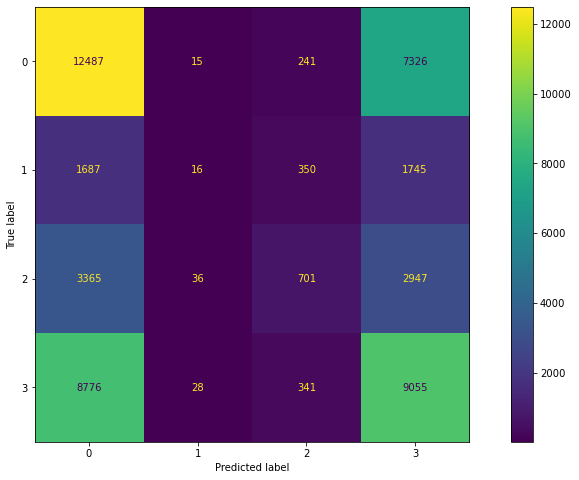

In [140]:
plot_confusion_matrix(xgbc, X_test, y_test)

Text(0.5, 0, 'Feature Importance')

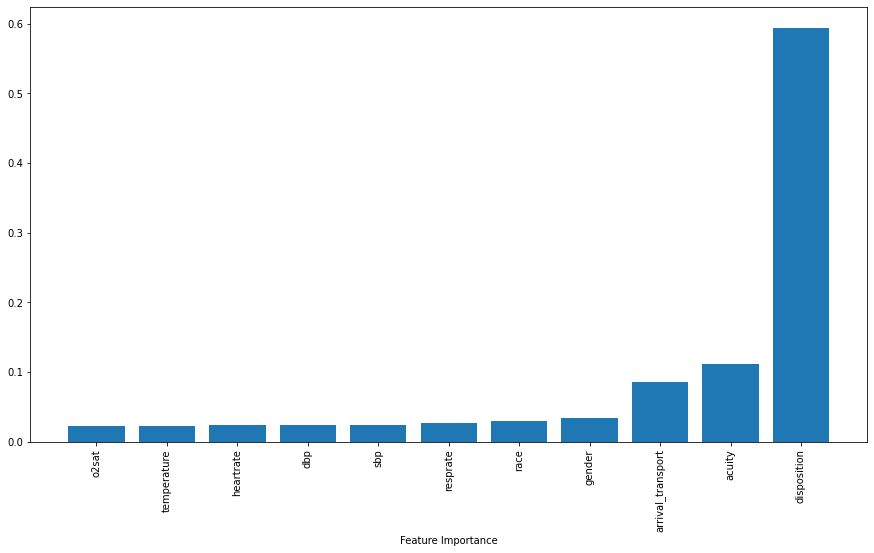

In [141]:
sort = xgbc.feature_importances_.argsort()
plt.bar(df.columns[sort], xgbc.feature_importances_[sort])
plt.xticks(rotation=90)
plt.xlabel("Feature Importance")

## Summary

##### 1. Null model has no performance while others do, some better than others which means that models are learning.
##### 2. Random Forest Classifier was the best model in terms of predictiion, followed by XGBoost, which gave bad results than what was expected, but can be improved further with hyperparameters optimization.
##### 3. The traditional machine learning models showed the possibility of predicting the stay of the patients.
##### 4. Some data balancing techniques can be tried to improve the models performance.
##### 5. Hyperparameter tuning is another aspect to look at.
##### 6. Can use more advance and complex models.
##### 7. Can try out neural networks and hybrid neaural networks.
##### 8. NLP should also be taken in account on text data during further work.
##### 9. Feature Importance can also be given some weightage in the next tasks.

In [144]:
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

In [145]:
df

,Stay,gender,race,arrival_transport,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,0,0,28,0,0,98.4,70.0,16.0,97.0,106.0,63.0,3.0
1,0,0,28,0,0,98.9,88.0,18.0,97.0,116.0,88.0,3.0
2,2,0,28,0,0,99.4,105.0,18.0,96.0,106.0,57.0,3.0
3,3,0,28,0,0,98.7,77.0,16.0,98.0,96.0,50.0,2.0
4,3,1,28,4,0,97.5,78.0,16.0,100.0,114.0,71.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
173733,2,1,7,4,0,98.0,91.0,16.0,99.0,148.0,90.0,2.0
173734,0,1,7,4,0,98.8,92.0,18.0,100.0,122.0,77.0,3.0
173735,3,1,7,4,0,98.6,80.0,18.0,100.0,161.0,100.0,3.0
173736,3,0,28,0,0,96.6,112.0,18.0,100.0,110.0,82.0,2.0


Text(0.5, 1.0, 'Correlation of Stay with other variables')

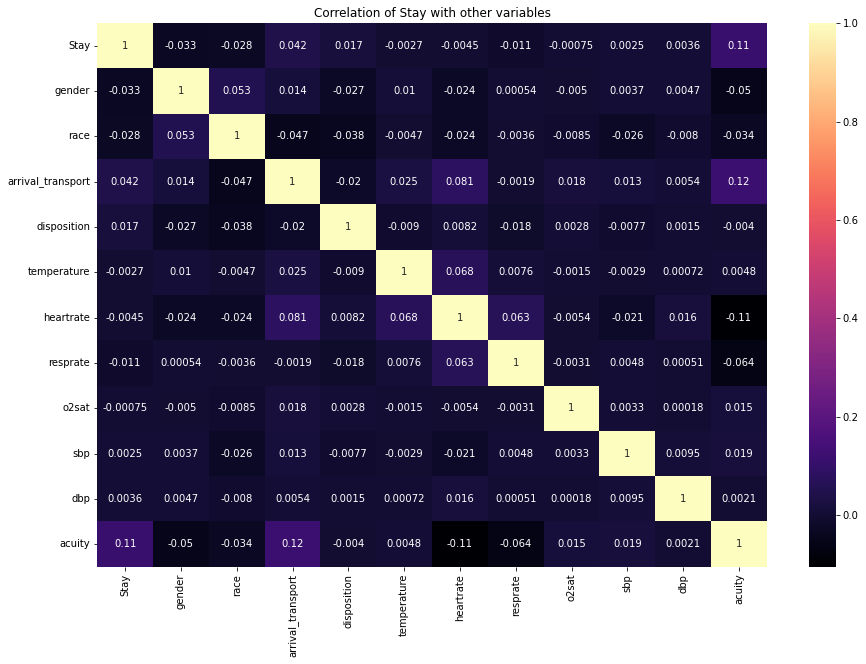

In [146]:
plt.figure(figsize=(15, 10))
ax = plt.axes()
sns.heatmap(df.corr(), cmap="magma",annot=True, ax = ax)
ax.set_title('Correlation of Stay with other variables')